# Setup

In [1]:
import contracts
contracts.disable_all()

In [16]:
import duckietown_world as dw
from duckietown_world.svg_drawing.ipython_utils import ipython_draw_html
import geometry as g
import numpy as np
import networkx as nx
import copy

import sys
sys.path.append("/home/jose/code/duckietown/duckietown-uplan/lib-uplan/")
import utils.augmentation as aug
import utils.segmentify as seg

ImportError: No module named 'utils.lane_segment'

In [3]:
dw.logger.setLevel(50)

Better visualization of output

In [4]:
%%html
<style>
pre {line-height: 90%}
</style>

# Road Network
Let's load a map and compute the road network.

In [5]:
m = dw.load_map('4way')


Use the function `get_skeleton_graph`:

In [6]:
sk = dw.get_skeleton_graph(m)

The return type is `SkeletonGraphResult`. It contains in `sk.root2` a new map with the joined lane segments. 

In [7]:
ipython_draw_html(sk.root2);

While in the attribute `sk.G` we find a graph describing the topology.

This is a graph where each node is a meeting point between lanes, and each edge represents a lane.

In [8]:

aug_graph = aug.augment_graph(sk.G, num_right = 1, num_left = 2, dist = 0.05)

Let's bring in the `draw_graph` function from some time ago.

In [9]:
def draw_graph(G0, pos=None):
    import networkx as nx
    from matplotlib import pyplot as plt
    pos = pos or nx.spring_layout(G0)
    plt.figure(figsize=(12, 12))    
    nx.draw(G0,pos,labels={}, node_size=10) # node:node for node in G0.nodes()
    nx.draw_networkx_edge_labels(G0,pos,edge_labels={},font_color='red')
    plt.axis('off')
    plt.show()

Set the position of each node in the graph based on the attribute 'point'.

In [10]:
%matplotlib inline

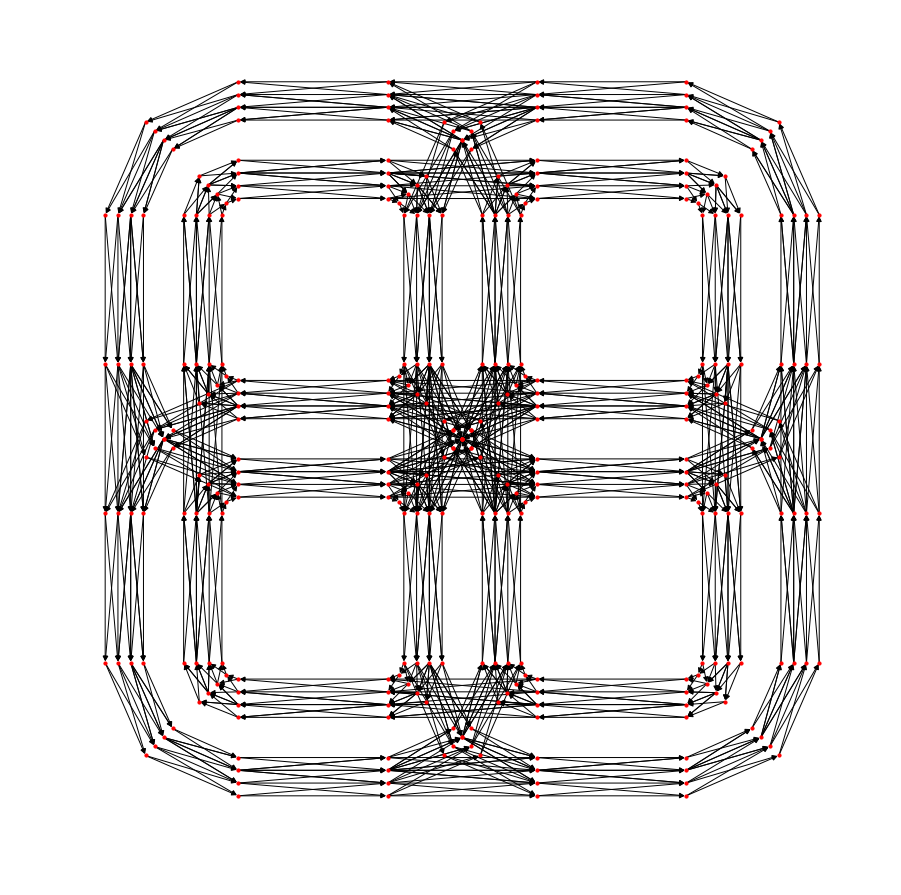

In [11]:
import geometry as geo
pos = {}
for n in aug_graph:
    q = aug_graph.nodes[n]['point'].as_SE2()
    t, _ = geo.translation_angle_from_SE2(q)
    pos[n] = t
draw_graph(aug_graph, pos=pos)